# Time Series SVR Algorithm

This algorithm is used to forecast FOREX prices for the EURUSD pair. It fetches data from MetaTrader5 and applies feature engineering to create additional data.

The forecasted values are set to:
- **Position 1** if the prediction indicates that the price will go up in the next hour
- **Position 0** if the prediction indicates that the price will go down in the nex hourx hour

### Dependencies & Prerequisites

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
from matplotlib import cycler
import warnings
warnings.filterwarnings("ignore")
import ta
import seaborn as sns
import MetaTrader5 as mt5
from datetime import datetime
from UsefulFunctions import data, backtest

In [4]:
# Initiate bound between MetaTrader5 and Python
mt5.initialize()

True

In [415]:
# Fetching data from MetaTrader5 from 2015 to the present using the custom function "get_rates" from the data.py file
# The historical data retrieved is of 1-hour timeframe
df = data.get_rates("USDJPY", mt5.TIMEFRAME_H1, datetime(2015,1,1))
df.head()

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2015-01-02 08:00:00,120.42,120.44,120.33,120.39,262,30,0
2015-01-02 09:00:00,120.40,120.50,120.38,120.43,599,30,0
2015-01-02 10:00:00,120.44,120.48,120.34,120.34,832,30,0
2015-01-02 11:00:00,120.33,120.42,120.31,120.40,761,30,0
2015-01-02 12:00:00,120.41,120.47,120.37,120.43,484,30,0


In [417]:
# Drop columns spread and real_volume and remane columns tick_volumne to volumne
df = df[["open", "high", "low", "close", "tick_volume"]]
df.rename(columns={'tick_volume': 'volume'}, inplace=True)
df.head()

,open,high,low,close,volume
time,,,,,
2015-01-02 08:00:00,120.42,120.44,120.33,120.39,262
2015-01-02 09:00:00,120.40,120.50,120.38,120.43,599
2015-01-02 10:00:00,120.44,120.48,120.34,120.34,832
2015-01-02 11:00:00,120.33,120.42,120.31,120.40,761
2015-01-02 12:00:00,120.41,120.47,120.37,120.43,484


## Feature engineering 
**Creating new input variables from raw data**

In [420]:
# Create a second DataFrame from the close column and compute the percent change in a new column
df_copy = df[["close"]]
df_copy["pct_change"] = df_copy["close"].pct_change(1)
df_copy.head()

,close,pct_change
time,,
2015-01-02 08:00:00,120.39,NaN
2015-01-02 09:00:00,120.43,0.000332
2015-01-02 10:00:00,120.34,-0.000747
2015-01-02 11:00:00,120.40,0.000499
2015-01-02 12:00:00,120.43,0.000249


In [430]:
# New DataFrame with all indications from "ta" library and shifting them by one row
df_indicators = ta.add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume", fillna=True).shift(1)
df_indicators

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02 09:00:00,120.420,120.440,120.330,120.390,262.0,2.381818e+01,262.0,0.090909,0.000000,0.000000,0.000000,0.000000,120.386667,50.000000,1000.000000,120.390000,120.390000,120.390000,0.000000,0.000000,0.0,0.0,120.386667,120.496667,120.276667,0.182744,0.515152,0.0,0.0,120.330,120.440,120.3850,0.091370,0.545455,0.000000,0.000000,0.000000,0.000000,0.000000,120.390000,120.390000,120.390000,120.390000,0.000000,0.000000,0.000000,1.161711,1.000000,-1.372719,11.533783,11.533783,0.000000,120.3850,120.385,120.38500,120.3850,0.000000,0.000000,0.000000,0.000000,0.000000,118.995167,118.968203,0.0,0.0,0.0,120.310000,120.440000,0.0,0.0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,54.545455,54.545455,-45.454545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.390000,0.000000,0.000000,0.000000
2015-01-02 10:00:00,120.400,120.500,120.380,120.430,599.0,-7.601515e+01,861.0,-0.088287,23.960000,1101.836394,1101.836394,0.199020,120.421452,100.000000,1000.000000,120.410000,120.450000,120.370000,0.066440,0.750000,0.0,0.0,120.411667,120.526667,120.296667,0.191011,0.579710,0.0,0.0,120.330,120.500,120.4150,0.141184,0.588235,0.000000,0.000000,0.003191,0.000638,0.002553,120.410000,120.410000,120.396154,120.392963,0.110195,0.038892,0.071303,0.000065,2.014493,-1.392719,11.701826,11.617804,0.084021,120.4150,120.415,120.41500,120.4150,0.000000,0.000000,0.000000,0.000000,66.666667,118.995167,118.968203,4.0,0.0,4.0,120.310000,120.440000,0.0,0.0,100.000000,0.000000,0.000000,0.000000,100.000000,21.739130,58.823529,56.684492,-41.176471,0.000000,0.000000,0.002650,0.000530,0.002120,9.368174,1.873635,7.494540,120.407778,0.033225,0.033220,0.033225
2015-01-02 11:00:00,120.440,120.480,120.340,120.340,832.0,-9.080152e+02,29.0,-0.536335,9.840000,-504.807692,298.514351,-0.422752,120.404357,41.868946,1000.000000,120.386667,120.460302,120.313031,0.122332,0.183125,0.0,0.0,120.403333,120.526667,120.280000,0.204867,0.243243,0.0,0.0,120.330,120.500,120.4150,0.141212,0.058824,0.000000,0.000000,-0.001525,0.000206,-0.001731,120.386667,120.386667,120.387515,120.389040,0.160455,0.130741,0.029714,0.000024,3.065995,-1.369386,11.505776,11.580462,-0.074686,120.4150,120.

In [423]:
# Making sure all columns are shown
pd.set_option('display.max_columns', None)

In [432]:
# Here I concatenated both dataframes and drop the close column (which wasn't shifted) from df_copy
df_to_work = pd.concat((df_indicators, df_copy["pct_change"]), axis=1)
df_to_work.dropna(inplace=True)
df_to_work

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,pct_change
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 09:00:00,120.420,120.440,120.330,120.390,262.0,2.381818e+01,262.0,0.090909,0.000000,0.000000,0.000000,0.000000,120.386667,50.000000,1000.000000,120.390000,120.390000,120.390000,0.000000,0.000000,0.0,0.0,120.386667,120.496667,120.276667,0.182744,0.515152,0.0,0.0,120.330,120.440,120.3850,0.091370,0.545455,0.000000,0.000000,0.000000,0.000000,0.000000,120.390000,120.390000,120.390000,120.390000,0.000000,0.000000,0.000000,1.161711,1.000000,-1.372719,11.533783,11.533783,0.000000,120.3850,120.385,120.38500,120.3850,0.000000,0.000000,0.000000,0.000000,0.000000,118.995167,118.968203,0.0,0.0,0.0,120.310000,120.440000,0.0,0.0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,54.545455,54.545455,-45.454545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.390000,0.000000,0.000000,0.000000,0.000332
2015-01-02 10:00:00,120.400,120.500,120.380,120.430,599.0,-7.601515e+01,861.0,-0.088287,23.960000,1101.836394,1101.836394,0.199020,120.421452,100.000000,1000.000000,120.410000,120.450000,120.370000,0.066440,0.750000,0.0,0.0,120.411667,120.526667,120.296667,0.191011,0.579710,0.0,0.0,120.330,120.500,120.4150,0.141184,0.588235,0.000000,0.000000,0.003191,0.000638,0.002553,120.410000,120.410000,120.396154,120.392963,0.110195,0.038892,0.071303,0.000065,2.014493,-1.392719,11.701826,11.617804,0.084021,120.4150,120.415,120.41500,120.4150,0.000000,0.000000,0.000000,0.000000,66.666667,118.995167,118.968203,4.0,0.0,4.0,120.310000,120.440000,0.0,0.0,100.000000,0.000000,0.000000,0.000000,100.000000,21.739130,58.823529,56.684492,-41.176471,0.000000,0.000000,0.002650,0.000530,0.002120,9.368174,1.873635,7.494540,120.407778,0.033225,0.033220,0.033225,-0.000747
2015-01-02 11:00:00,120.440,120.480,120.340,120.340,832.0,-9.080152e+02,29.0,-0.536335,9.840000,-504.807692,298.514351,-0.422752,120.404357,41.868946,1000.000000,120.386667,120.460302,120.313031,0.122332,0.183125,0.0,0.0,120.403333,120.526667,120.280000,0.204867,0.243243,0.0,0.0,120.330,120.500,120.4150,0.141212,0.058824,0.000000,0.000000,-0.001525,0.000206,-0.001731,120.386667,120.386667,120.387515,120.389040,0.160455,0.130741,0.029714,0.000024,3.065995,-1.369386,11.505776,11.580462,-0.074686,120.4150,120.415,120.41500,120.4150,0.000000,0.000000,0.000000,0.000000,-50.000000,118.995167,118.968203,4.0,0.0,4.0,120.310000,120.440000,0.0,1.0,29.213483,0.000000,0.000000,0.000000,95.121951,13.513514,5.882353,39.750446,-94.117647,0.000000,0.000000,-0.001267,0.000171,-0.001437,20.231822,5.545272,14.686550,120.377543,-0.074732,-0.074760,-0.041532,0.000499
2015-0

In [436]:
# Making sure some columns are not full of 0 values to avoid interference in the model
non_zero_rows = df_to_work[df_to_work['trend_psar_down_indicator'] != 0]

# Display the rows where the specified column has non-zero values
non_zero_rows.head()


,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,pct_change
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 11:00:00,120.44,120.48,120.34,120.34,832.0,-908.015152,2.900000e+01,-0.536335,9.840000,-504.807692,298.514351,-0.422752,120.404357,41.868946,1000.000000,120.386667,120.460302,120.313031,0.122332,0.183125,0.0,0.0,120.403333,120.526667,120.280000,0.204867,0.243243,0.0,0.0,120.33,120.50,120.415,0.141212,0.058824,0.000000,0.000000,-0.001525,0.000206,-0.001731,120.386667,120.386667,120.387515,120.389040,0.160455,0.130741,0.029714,0.000024,3.065995,-1.369386,11.505776,11.580462,-0.074686,120.415,120.415,120.4150,120.415,0.000000,0.000000,0.000000,0.000000,-50.000000,118.995167,118.968203,4.0,0.0,4.0,120.310000,120.44,0.0,1.0,29.213483,0.000000,0.000000,0.000000,95.121951,13.513514,5.882353,39.750446,-94.117647,0.000000,0.000000,-0.001267,0.000171,-0.001437,20.231822,5.545272,14.686550,120.377543,-0.074732,-0.074760,-0.041532,0.000499
2015-01-02 18:00:00,120.62,120.63,119.99,120.19,1586.0,-182.984091,7.620000e+02,-0.027061,-90.381127,-13720.050441,-720.119671,-5.235766,120.432093,51.136108,1001.080273,120.455000,120.731442,120.178558,0.458996,0.020695,0.0,0.0,120.458333,120.630333,120.286333,0.285576,-0.280039,0.0,1.0,119.99,120.73,120.360,0.614337,0.270270,0.177000,0.000000,0.022107,0.020532,0.001575,120.455000,120.455000,120.450322,120.428215,0.411974,0.460632,-0.048658,0.002284,10.818619,-1.437719,12.079922,11.836364,0.243558,120.360,120.360,120.3600,120.360,0.000000,0.000000,0.000000,0.000000,-133.569740,118.995167,118.968203,32.0,36.0,-4.0,120.339974,120.73,0.0,1.0,35.257169,0.000000,0.000000,0.000000,62.955087,46.731235,27.027027,66.805461,-72.972973,0.056000,0.000000,0.018357,0.017049,0.001308,34.054588,20.721731,13.332857,120.430360,-0.406032,-0.406859,-0.166127,0.000083
2015-01-05 15:00:00,120.27,120.28,120.03,120.15,800.0,1921.963378,1.844674e+19,0.076007,-23.486963,-5312.500000,-686.436125,-6.120087,120.330239,35.263291,999.087826,120.362500,120.586632,120.138368,0.372428,0.025948,0.0,0.0,120.361333,120.571333,120.151333,0.348949,-0.003175,0.0,1.0,119.97,120.64,120.305,0.556652,0.268657,0.213493,0.241937,-0.039215,-0.015032,-0.024183,120.357500,120.385000,120.319572,120.358787,0.903427,1.102804,-0.199377,-0.001612,27.495198,0.027500,3.935198,5.628837,-1.693638,120.335,120.265,120.3000,120.265,5.436326,23.128549,13.771932,30.698680,-150.243421,120.405000,120.405000,12.0,20.0,-8.0,120.079127,120.64,0.0,1.0,40.563685,0.000000,0.203962,0.218959,1.625849,47.982423,26.865672,42.288557,-73.134328,-0.109935,-0.083160,-0.032582,-0.012488,-0.020093,7.163938,8.082608,-0.918670,120.396881,-0.091468,-0.091510,-0.

## Machine Learning Section

In [439]:
# Splitting the data into features and labels for the ML model using the custom function "split_data" from data.py file
X = df_to_work.iloc[:,:-1]
y = df_to_work["pct_change"]

X_train, y_train, X_test, y_test = data.split_data(X, y)

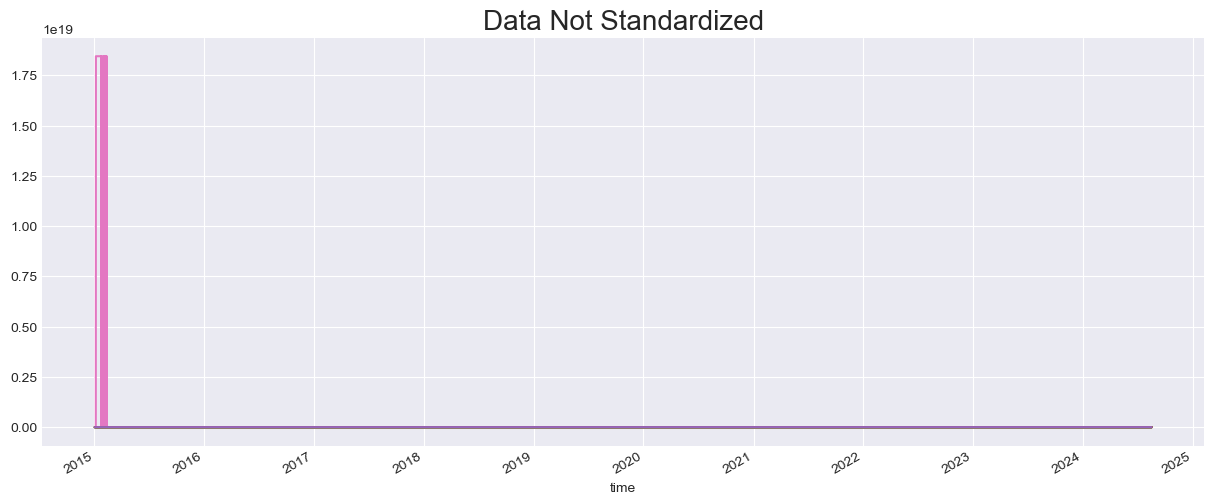

In [441]:
# Plotting features before standardization to visualize their unequal scales (plot shows only the first 15 indicators)
X.iloc[:,:15].plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Data Not Standardized", fontsize=20)
plt.show()

### Standardizing The Data

In [444]:
from sklearn.preprocessing import StandardScaler

In [446]:
# Only the feature sets (X) need to be standardized, not the targets (y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

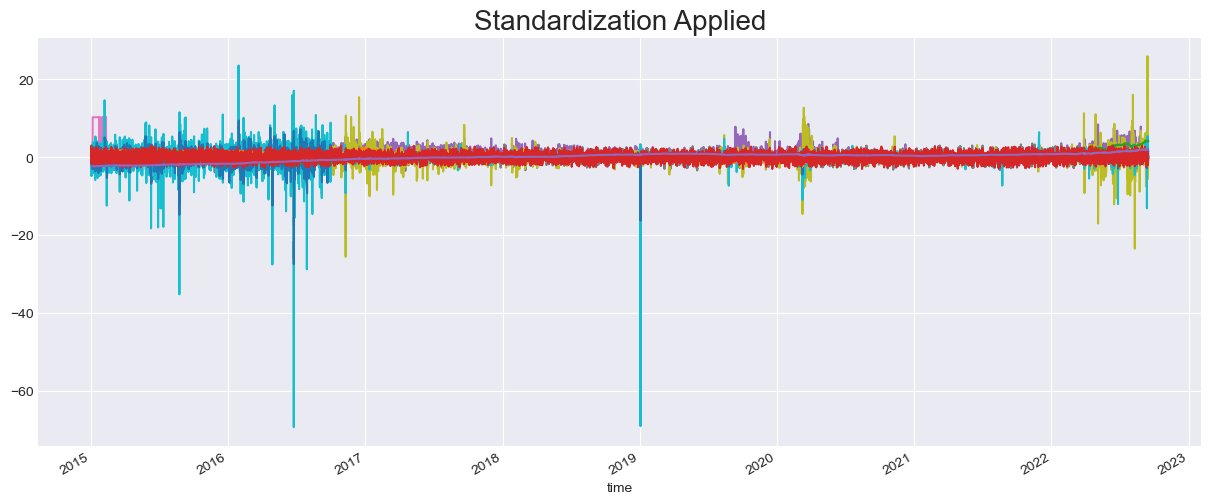

In [448]:
# Plotting the standardized data for the indicators (plot shows only form the first 15 indicatos)
pd.DataFrame(X_train_scaled, index=X_train.index, columns=X.columns).iloc[:,:15].plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Standardization Applied", fontsize=20);

### Applying PCA

**Principal Component Analysis (PCA)** is a dimensionality reduction technique used in machine learning and data analysis. Its primary goal is to reduce the number of features (variables) in a dataset while retaining as much information as possible

In [452]:
from sklearn.decomposition import PCA

In [454]:
# Initialize the class
pca = PCA(n_components=7)

# New Data Sets
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [456]:
# Showing the new shape of X data sets (both have now only 7 columns)
X_train_pca.shape, X_test_pca.shape

((47825, 7), (11957, 7))

## Training The SVR Model

In [339]:
from sklearn.svm import SVR

In [575]:
# Initializing the SVR class
svr = SVR(epsilon=0.1)

# Training the Model
svr.fit(X_train_pca, y_train)

# Making predictions
predictions = svr.predict(X_test_pca)

Text(0.5, 1.0, 'Direction of the Model Predictions')

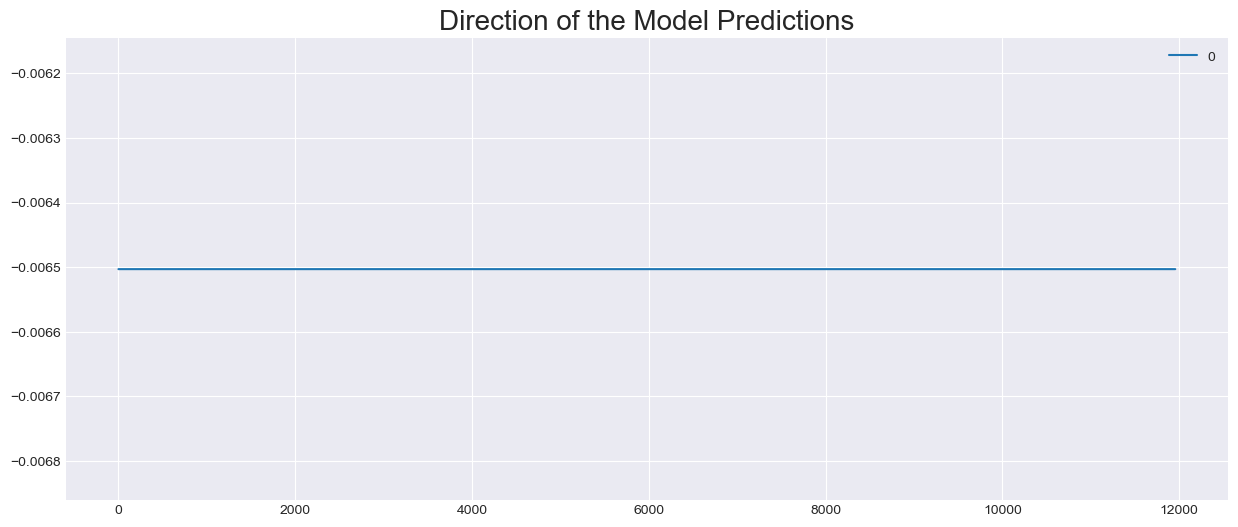

In [577]:
# Plotting to visualize predictions to make sure go in both directions
pd.DataFrame(predictions).plot(figsize=(15,6))
plt.title("Direction of the Model Predictions", fontsize=20)

**With epsilon default values 0.1 we have not results so I set it to 0.01**

In [579]:
# Initializing the SVR class
svr = SVR(epsilon=0.01)

# Training the Model
svr.fit(X_train_pca, y_train)

# Making predictions
predictions = svr.predict(X_test_pca)

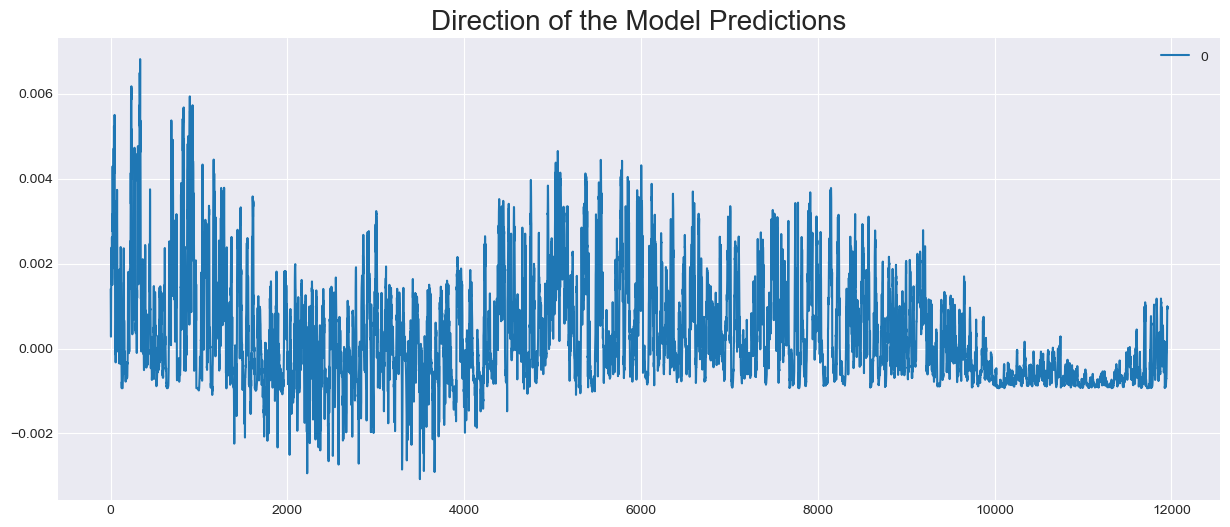

In [581]:
# Plotting to visualize predictions to make sure go in both directions
pd.DataFrame(predictions).plot(figsize=(15,6))
plt.title("Direction of the Model Predictions", fontsize=20);

## SVR Model Analysis

**Compute Returns for SVR Model**

In [514]:
returns =backtest.compute_strategy_returns(y_test, predictions)
returns

,pct_change,prediction,real_position,pred_position,returns
time,,,,,
2022-09-15 07:00:00,0.000523,-0.006503,1.0,-1.0,-0.000523
2022-09-15 08:00:00,0.000718,-0.006503,1.0,-1.0,-0.000718
2022-09-15 09:00:00,0.000599,-0.006503,1.0,-1.0,-0.000599
2022-09-15 10:00:00,-0.000787,-0.006503,-1.0,-1.0,0.000787
2022-09-15 11:00:00,-0.000947,-0.006503,-1.0,-1.0,0.000947
...,...,...,...,...,...
2024-08-16 19:00:00,-0.000878,-0.006503,-1.0,-1.0,0.000878
2024-08-16 20:00:00,-0.001743,-0.006503,-1.0,-1.0,0.001743
2024-08-16 21:00:00,-0.000494,-0.006503,-1.0,-1.0,0.000494


**Plot returns from SVR Model Predictions**

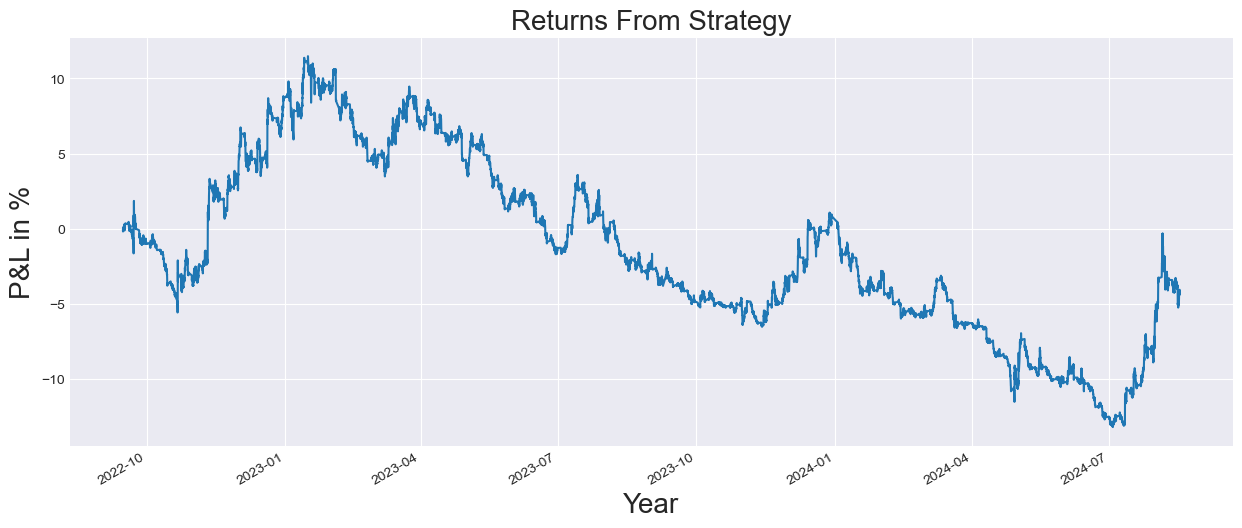

In [516]:
backtest.plot_returns(returns["returns"])

**SVR Model Accuracy Analysis**

Counts of 0 indicate instances where the predicted position did not match the real position.
Counts of 1 indicate instances where the predicted position matched the real position.

accuracy
0    6259
1    5698
Name: count, dtype: int64

Model has an accuracy of: 47.65%


,real_position,pred_position,accuracy
time,,,
2022-09-15 07:00:00,1.0,-1.0,0
2022-09-15 08:00:00,1.0,-1.0,0
2022-09-15 09:00:00,1.0,-1.0,0
2022-09-15 10:00:00,-1.0,-1.0,1
2022-09-15 11:00:00,-1.0,-1.0,1
...,...,...,...
2024-08-16 19:00:00,-1.0,-1.0,1
2024-08-16 20:00:00,-1.0,-1.0,1
2024-08-16 21:00:00,-1.0,-1.0,1


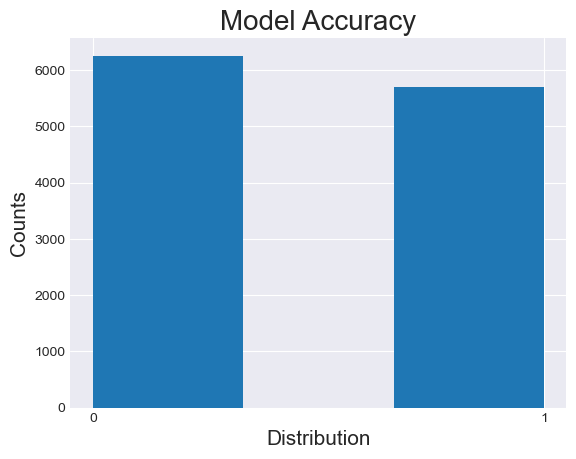

In [518]:
backtest.compute_model_accuracy(returns["real_position"], returns["pred_position"])

**Vectorizing The Strategy Backtest**

In [530]:
# This functions in on Backtest.py file
backtest.vectorize_backtest_returns(returns["returns"], 24)

Sortino Ratio: -0.275
- Negative Sortino (< 0): The investment’s returns are less than the target return when considering downside risk.

***Asset for Benchamark is S&P500***

Beta Ratio: 0.104
- Beta < 1: The asset is less volatile than the market (considered less risky).

Alpha Ratio: -1.838
- Negative Alpha (< 0): The investment underperformed the market.


**Strategy Model Drawdown**

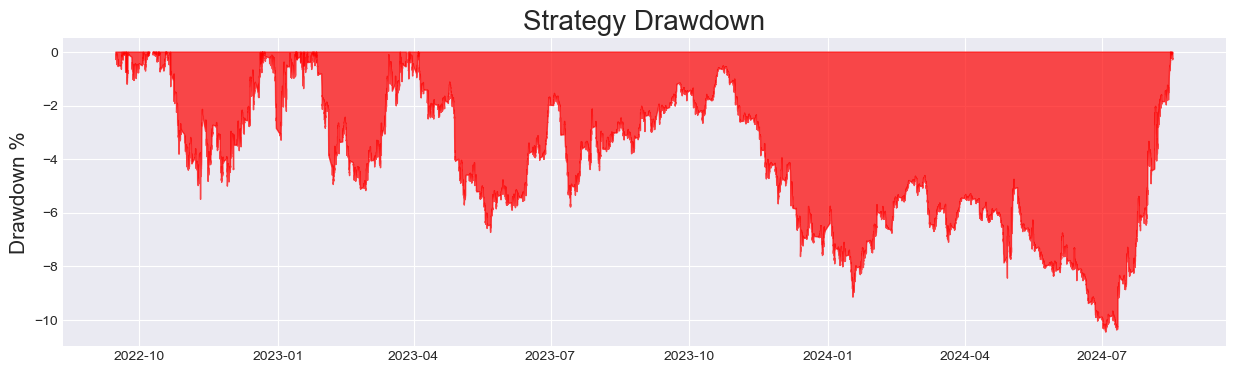

Max Drawdown: -10.47%


In [503]:
backtest.strategy_drawdown(returns["returns"])

## Testing Linear Regression Model on These Datasets

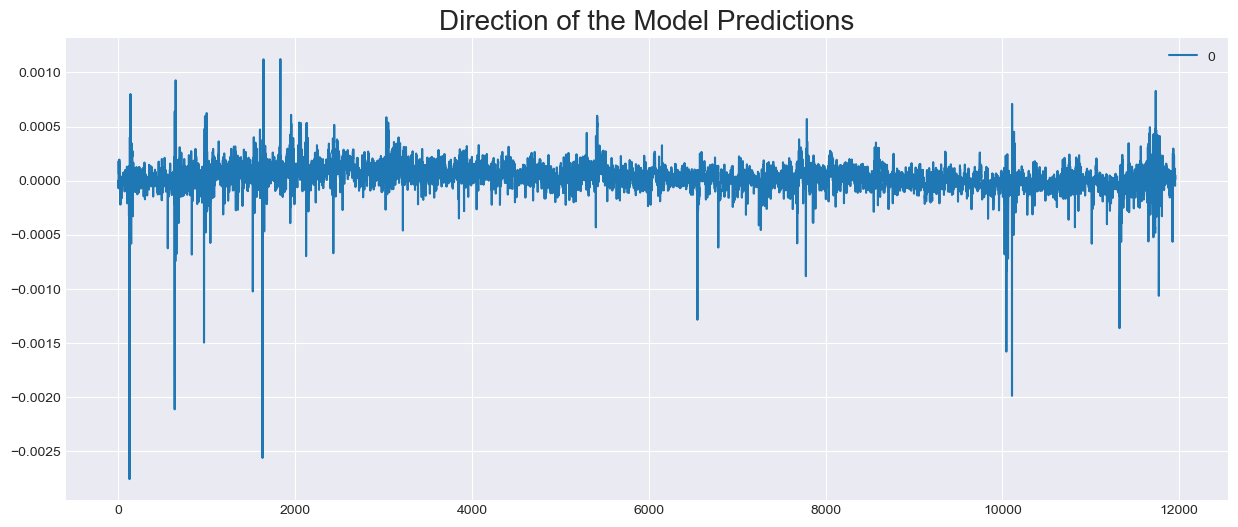

In [594]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()

# Training the model
regressor.fit(X_train_scaled, y_train)

# Making predictions
predictions2 = regressor.predict(X_test_scaled)

# Plotting to visualize predictions to make sure go in both directions
pd.DataFrame(predictions2).plot(figsize=(15,6))
plt.title("Direction of the Model Predictions", fontsize=20);

**Compute Returns for Linear Regression Model**

In [537]:
returns2 = backtest.compute_strategy_returns(y_test, predictions2)
returns2

,pct_change,prediction,real_position,pred_position,returns
time,,,,,
2022-09-15 07:00:00,0.000523,0.000001,1.0,1.0,0.000523
2022-09-15 08:00:00,0.000718,-0.000071,1.0,-1.0,-0.000718
2022-09-15 09:00:00,0.000599,0.000180,1.0,1.0,0.000599
2022-09-15 10:00:00,-0.000787,0.000137,-1.0,1.0,-0.000787
2022-09-15 11:00:00,-0.000947,0.000089,-1.0,1.0,-0.000947
...,...,...,...,...,...
2024-08-16 19:00:00,-0.000878,-0.000006,-1.0,-1.0,0.000878
2024-08-16 20:00:00,-0.001743,-0.000047,-1.0,-1.0,0.001743
2024-08-16 21:00:00,-0.000494,-0.000047,-1.0,-1.0,0.000494


**Plot returns from Linear Regression Model Predictions**

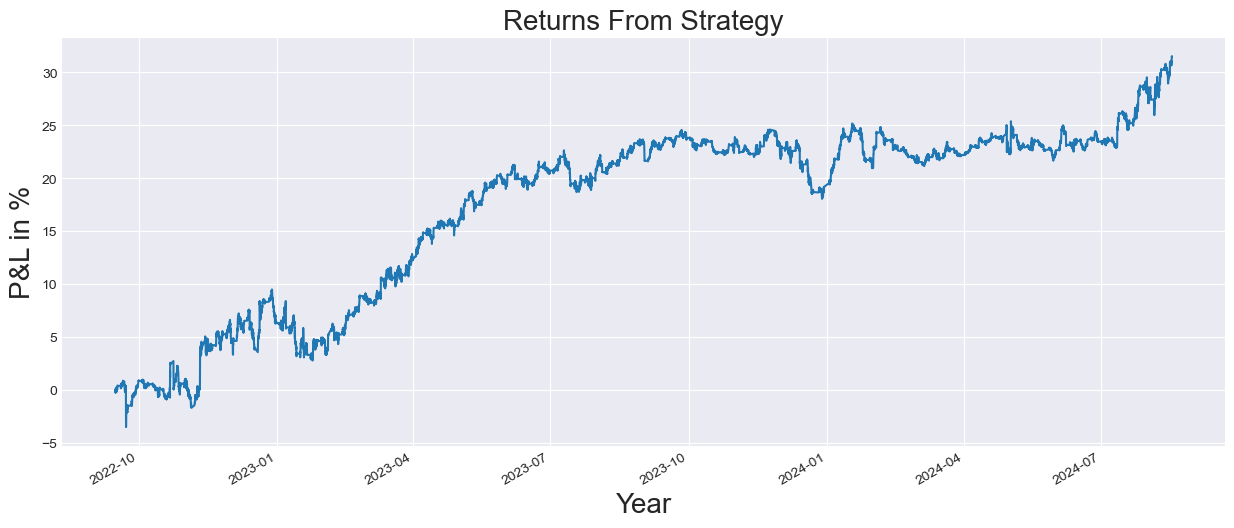

In [586]:
backtest.plot_returns(returns2["returns"])

**Linear Regression Model Accuracy Analysis**

Counts of 0 indicate instances where the predicted position did not match the real position.
Counts of 1 indicate instances where the predicted position matched the real position.

accuracy
1    6011
0    5946
Name: count, dtype: int64

Model has an accuracy of: 50.27%


,real_position,pred_position,accuracy
time,,,
2022-09-15 07:00:00,1.0,1.0,1
2022-09-15 08:00:00,1.0,-1.0,0
2022-09-15 09:00:00,1.0,1.0,1
2022-09-15 10:00:00,-1.0,1.0,0
2022-09-15 11:00:00,-1.0,1.0,0
...,...,...,...
2024-08-16 19:00:00,-1.0,-1.0,1
2024-08-16 20:00:00,-1.0,-1.0,1
2024-08-16 21:00:00,-1.0,-1.0,1


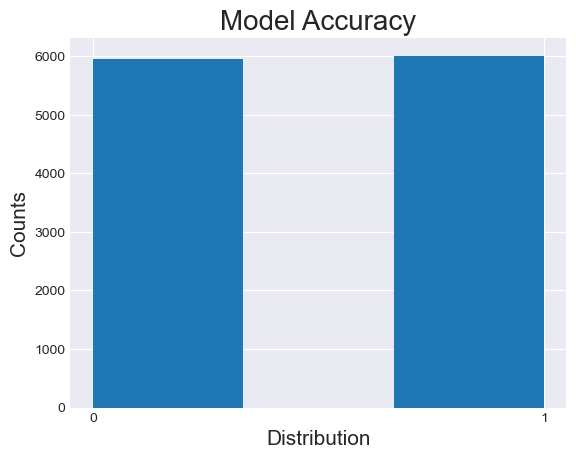

In [588]:
backtest.compute_model_accuracy(returns2["real_position"], returns2["pred_position"])

**Strategy Model Drawdown**

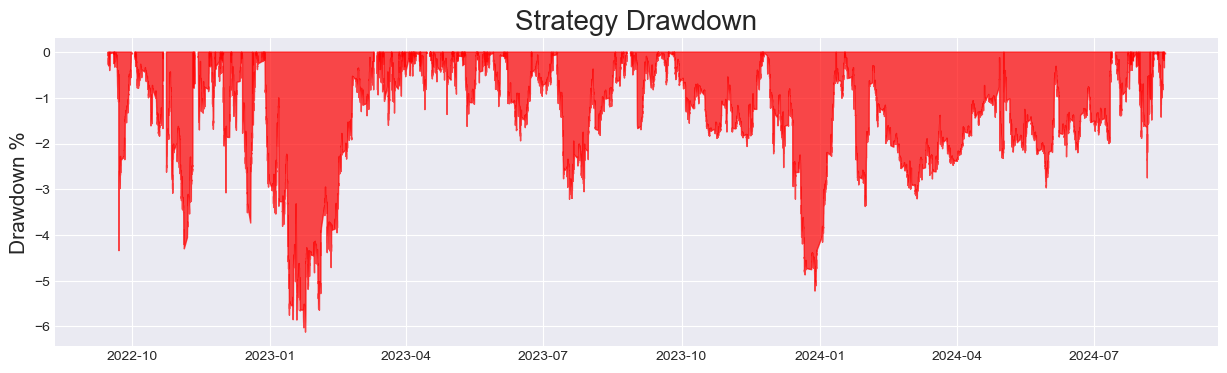

Max Drawdown: -6.12%


In [592]:
backtest.strategy_drawdown(returns2["returns"])